In [1]:
from joblib import Parallel, delayed, cpu_count
import funcy as fp
from multiprocessing import Pool

import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the maximum width of columns
pd.set_option('max_colwidth', 200)

In [2]:
# def _series_chunks(s, n_jobs):
#     if n_jobs < 0:
#         # so, have n chunks if we are using all n cores/cpus = cpu_count() + 1 + n_jobs
#         n_jobs = cpu_count() + 1 + n_jobs
#     n = len(s)
#     n_chunks = int(n / n_jobs)
#     return (s.iloc[ilocs] for ilocs in fp.chunks(n_chunks, range(n)))

# def series_pmap(s, f, n_jobs=-1):
#     if n_jobs == 0:
#         return s.map(f)
#     return pd.concat(Parallel(n_jobs=n_jobs)(delayed(series_pmap)(sub_series, f, n_jobs=0) \
#                                                  for sub_series in _series_chunks(s, n_jobs)))

In [3]:
%%time

conn = psycopg2.connect("host=localhost dbname=postgres user=postgres")

titles_df = sqlio.read_sql_query("SELECT id, title FROM bq_all", conn, index_col='id')

CPU times: user 314 ms, sys: 79.9 ms, total: 394 ms
Wall time: 1.81 s


In [4]:
tag_regex_dict = {
    "Python": r'python|pandas|numpy|scipy|matplotlib|pydata|django',
    "Mobile": r'mobile|android|iphone|phone|\bios\b|react native',
    "Design": r'design',
    "Security": r'security|worm|ransomware|attack|virus|patch|infosec',
    "Blockchain": r'blockchain|bitcoin|ethereum|solidity|dapps|smart contract',
    "AI/Machine Learning": r'\bai\b|artificial intelligence|machine learning|deep learning|tensorflow|machine intelligence|reinforcement learning|unsupervised learning|supervised learning|neural network|image classification',
    "Google": r'google|goog',
    "Microsoft": r'microsoft|msft|windows|visual studio|azure',
    "Apple": r'apple|aapl|mac\b|os ?x',
    "Facebook": r'facebook|\bfb\b',
    "Amazon": r'amazon|amzn|\baws\b',
    "Startups": r'startup|\bvc\b',
    "Politics": r'trump|comey|russian|fbi|snowden|neutrality|white house|government|brexit|nsa',
    "Databases": r'sql|cockroachdb|mongodb|mariadb|orientdb|couchdb|database|\bdb\b|dbms|oltp|\bolap\b|neo4j|\bredis\b',
    "Linux": r'linux|debian|ubuntu|centos',
    "Data Science": r'data scien|big data|data vi|data ?set|data analy|machine learning|pandas|ggplot2|numpy|scipy|matplotlib|pydata|statistical learning|statistical program|\bsas\b|spss|bayesian|frequentist',
    "Science": r'bio|drug|researcher|genomic|physics|scienti|spacex|\\bmoon\\b|nasa|\\bastro|\\bmars\\b',
    "Math": r'math|geome|cryptograph|algebra|calculus|graph theory|game theory|differential equations|trigonometry',
    "Javascript": r'javascript|jquery|d3|angular|redux|\.js|ecmascript|\bvue',
    "Web Dev": r'web app|javascript|\.js|front.?end|ruby on rails|django|css|web.*dev',
    "DevOps": r'sys.*admin|dev.*ops|kubernetes|docker|containerization|container|virtualization|serverless|continuous integration|continuous deployment|continuous delivery|site reliability|ec2|\bebs\b',
    "Hardware/IoT": r'raspberry pi|electronics|analog computer|arduino|micro.?controller|micro.?processor|\biot\b|internet of things',
    "AR/VR": r'augmented reality|\bar\b|virtual reality|\bvr\b|htc vive|oculus|google cardboard|hololens',
    "Games": r'steam gam|video gam|mobile gam|pc gam|indie gam|nintendo|\bsnes\b|gaming|game.*dev|unreal engine|xbox|rpg|multiplayer'
}

tags_list = list(tag_regex_dict.keys())

tags_dict = {tag: [] for tag in tags_list}

def tag_titles(title):
    lowercase = title.lower()
    for tag in tags_list:
        regex_pattern = tag_regex_dict[tag]
        if re.search(regex_pattern, lowercase): 
            tags_dict[tag].append(1)
        else:
            tags_dict[tag].append(0)

In [5]:
%%time

titles_df["title"].map(tag_titles)

CPU times: user 20.8 s, sys: 321 ms, total: 21.2 s
Wall time: 56.6 s


id
3714951     None
5006090     None
9903760     None
12328081    None
13295530    None
8054560     None
7327542     None
8961551     None
6415872     None
16008268    None
10482739    None
8099713     None
3670862     None
9128404     None
3709259     None
4412109     None
13351038    None
5678943     None
9736794     None
12328006    None
14567411    None
4793670     None
11074537    None
15670827    None
12000264    None
10978077    None
8433247     None
8206700     None
10240408    None
13413725    None
            ... 
5741622     None
11431108    None
8803138     None
8221524     None
10234432    None
7616697     None
4949981     None
13086059    None
11096598    None
13100851    None
5003980     None
9838595     None
9389116     None
7691289     None
15814907    None
11735020    None
15655866    None
3429054     None
10484493    None
11001725    None
5872829     None
16851165    None
3438134     None
12429445    None
4661913     None
16328068    None
14537595    None
3746227    

In [6]:
%%time

for tag, encoding in tags_dict.items():
    titles_df[tag] = encoding

CPU times: user 1.32 s, sys: 117 ms, total: 1.43 s
Wall time: 3.87 s


In [7]:
%%time

no_tags_ids = titles_df[(titles_df[list(tags_list)] == 0).all(axis=1)].index.values
tagged_df = titles_df.drop(index=no_tags_ids)

CPU times: user 489 ms, sys: 142 ms, total: 632 ms
Wall time: 1.79 s


In [8]:
tagged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 6415872 to 3746227
Data columns (total 25 columns):
title                  46685 non-null object
Python                 46685 non-null int64
Mobile                 46685 non-null int64
Design                 46685 non-null int64
Security               46685 non-null int64
Blockchain             46685 non-null int64
AI/Machine Learning    46685 non-null int64
Google                 46685 non-null int64
Microsoft              46685 non-null int64
Apple                  46685 non-null int64
Facebook               46685 non-null int64
Amazon                 46685 non-null int64
Startups               46685 non-null int64
Politics               46685 non-null int64
Databases              46685 non-null int64
Linux                  46685 non-null int64
Data Science           46685 non-null int64
Science                46685 non-null int64
Math                   46685 non-null int64
Javascript             46685 non-null int64
We

In [9]:
%%time

tag_count_df = tagged_df.sum(axis='index', numeric_only=True)

CPU times: user 16.4 ms, sys: 6.82 ms, total: 23.2 ms
Wall time: 45 ms


In [10]:
tag_count_df = tag_count_df.to_frame(name="count")
tag_count_df = tag_count_df.sort_values(by="count", ascending=False)
tag_count_df = tag_count_df.reset_index()

In [16]:
tag_count_df["count"] = tag_count_df["count"] / tag_count_df["count"].sum() * 100

In [19]:
tag_count_df.tail()

,index,count
19,DevOps,2.059648
20,Data Science,1.957915
21,Games,1.477806
22,Hardware/IoT,1.306466
23,AR/VR,0.696068


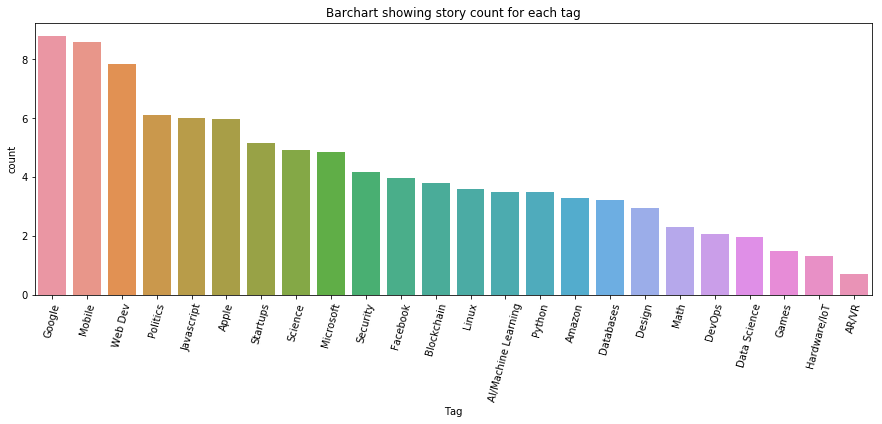

In [18]:
plt.figure(figsize=(15, 5))
sns.barplot(x="index", y="count", data=tag_count_df)
plt.xticks(rotation=75)
plt.title("Barchart showing story count for each tag")
plt.ylabel("Number of stories with tag")
plt.xlabel("Tag")
plt.show()

In [42]:
story_count_df = tagged_df.sum(axis='columns', numeric_only=True).to_frame(name="num_tags").groupby(['num_tags']).size().to_frame(name="count")

In [43]:
story_count_df

,count
num_tags,
1,38284
2,7536
3,797
4,59
5,8
6,1


In [13]:
# print("sup")